In [ ]:
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
numberOfPrev=5

In [ ]:
#Create a dataframe for the data from Tata Motors
df=pd.read_csv('TTM.csv')

In [ ]:
#Filter the dataframe to retain only necessary columns
required_fields=['Date','Close']
df= df[required_fields]

In [ ]:
#Change the type of 'Date' to datetime
df.Date=pd.to_datetime(df.Date)

In [ ]:
#Set Date as the index of dataframe
df=df.set_index(['Date'])
df.head()

,Close
Date,
2004-09-27,9.15
2004-09-28,8.76
2004-09-29,8.75
2004-09-30,8.97
2004-10-01,9.25


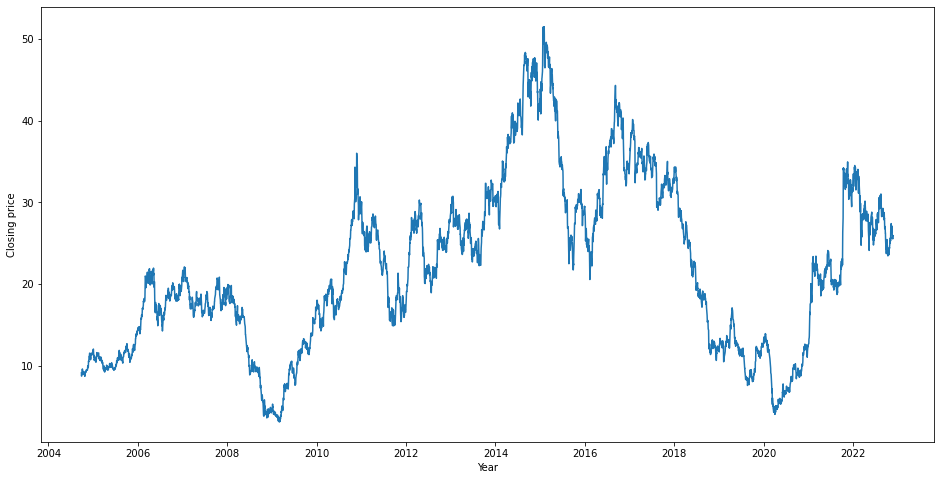

In [ ]:
#A plot depicting the close values across years
plt.figure(figsize=(16,8))
plt.plot(df['Close'])
plt.xlabel('Year')
plt.ylabel("Closing price")
plt.show()

In [ ]:
#This method takes a dataframe with 2 columns(Date and Close) and converts it into required format for training(Date, Close and Close values of previous 5 days)
def format_dataframe(df1,n):
  close=list(df['Close'])
  df1=df[n::]
  df1=df1.T 
  for i in range(1,n+1):
    day="Day-"+str(i)
    df1.loc[day,:]=close[n-i:-i]

  # df1.loc['Day-1',:]=close[4:-1]
  # df1.loc['Day-2',:]=close[3:-2]
  # df1.loc['Day-3',:]=close[2:-3]
  # df1.loc['Day-4',:]=close[1:-4]
  # df1.loc['Day-5',:]=close[:-5]
  return df1.T

In [ ]:
df=format_dataframe(df,numberOfPrev)

In [ ]:
##This method takes a dataframe of training(Date, Close and Close values of previous 5 days) and return numpy arrays of dates(dates),Input(X) and Actual Output(Y)
def obtain_training_data(df1,n):
  dates=list(df.index)
  columnList=[]
  for i in range(1,n+1):
    day="Day-"+str(i)
    columnList.append(df[day])
    
  x=list(list(x) for x in columnList)
  x=np.array(x).T
  X=x.reshape(len(dates),x.shape[1],1)
  y=list(df['Close'])
  return np.array(dates),X,np.array(y)

In [ ]:
dates,input, output=obtain_training_data(df,numberOfPrev)
input.shape,output.shape,dates.shape

((4569, 5, 1), (4569,), (4569,))

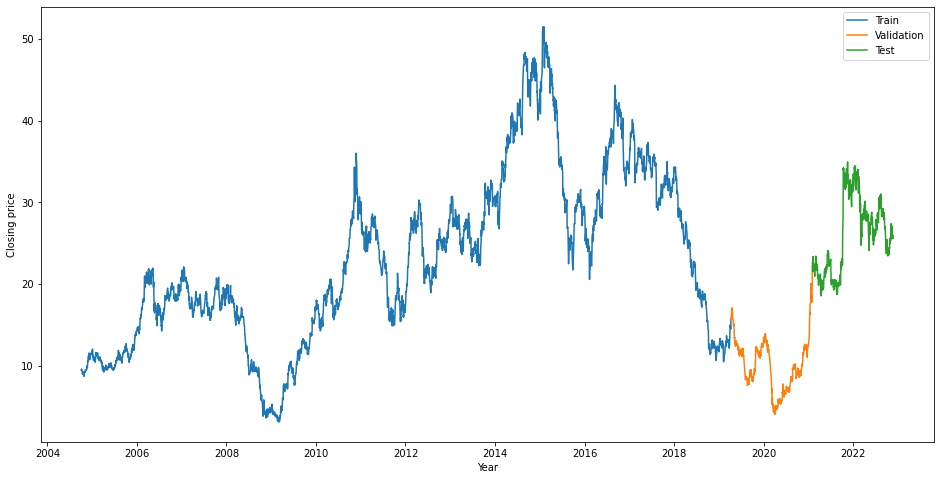

In [ ]:
#Splits dates, inputs and actual outputs to train,validation and test sets (80%-10%-10%)
lenEightyPercent = int(len(dates) * .8)
lenNinetyPercent= int(len(dates) * .9)

inputTrain = input[ :lenEightyPercent]
outputTrain = output[ :lenEightyPercent]
datesTrain =dates[ :lenEightyPercent]

inputVal = input[lenEightyPercent : lenNinetyPercent]
outputVal = output[lenEightyPercent : lenNinetyPercent]
datesVal =dates[lenEightyPercent : lenNinetyPercent]

inputTest = input[lenNinetyPercent: ]
outputTest = output[lenNinetyPercent: ]
datesTest =dates[lenNinetyPercent: ]

plt.figure(figsize=(16,8))
plt.plot(datesTrain, outputTrain)
plt.plot(datesVal, outputVal)
plt.plot(datesTest, outputTest)
plt.xlabel('Year')
plt.ylabel("Closing price")
plt.legend(['Train', 'Validation', 'Test'])
plt.show()

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
model=Sequential()
model.add(LSTM(units=64,return_sequences=True,input_shape=(numberOfPrev,1)))
model.add(LSTM(units=64))
# model.add(LSTM(50))
model.add(Dense(1))
# model.compile(loss='mean_squared_error',optimizer='adam')
# model = Sequential([layers.Input((100, 1)),
#                     layers.LSTM(64),
#                     layers.Dense(32, activation='relu'),
#                     layers.Dense(32, activation='relu'),
#                     layers.Dense(1)])

# model.compile(loss='mse', optimizer='adam')
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001),metrics=['mean_absolute_error'])


In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 5, 64)             16896     
                                                                 
 lstm_9 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(inputTrain,outputTrain,validation_data=(inputVal,outputVal),epochs=100)

Epoch 1/100
115/115 [==============================] - 6s 16ms/step - loss: 287.4295 - mean_absolute_error: 13.5838 - val_loss: 40.5294 - val_mean_absolute_error: 5.7454
Epoch 2/100
115/115 [==============================] - 1s 9ms/step - loss: 114.6040 - mean_absolute_error: 7.4901 - val_loss: 0.5506 - val_mean_absolute_error: 0.5662
Epoch 3/100
115/115 [==============================] - 1s 9ms/step - loss: 57.3217 - mean_absolute_error: 4.4105 - val_loss: 0.4176 - val_mean_absolute_error: 0.4694
Epoch 4/100
115/115 [==============================] - 1s 9ms/step - loss: 32.7779 - mean_absolute_error: 3.0055 - val_loss: 0.4270 - val_mean_absolute_error: 0.4993
Epoch 5/100
115/115 [==============================] - 1s 9ms/step - loss: 20.5677 - mean_absolute_error: 2.2548 - val_loss: 0.3839 - val_mean_absolute_error: 0.4471
Epoch 6/100
115/115 [==============================] - 1s 9ms/step - loss: 13.8029 - mean_absolute_error: 1.7745 - val_loss: 0.3368 - val_mean_absolute_error: 0.4311

115/115 [==============================] - 0s 3ms/step
(3655, 5, 1)
(3655,)
[ 9.532598  9.74079   9.899564 ... 15.124401 14.700469 14.9319  ]


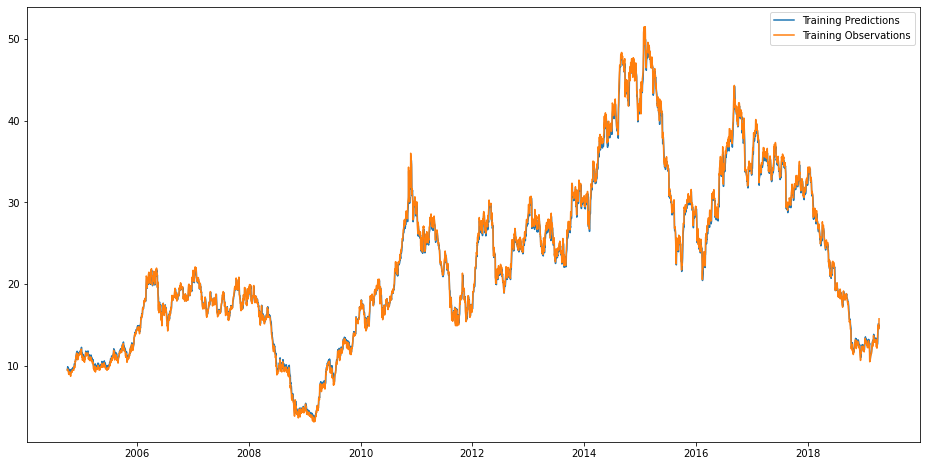

In [ ]:
train_predictions = model.predict(inputTrain).flatten()
print(inputTrain.shape)
print(train_predictions.shape)
print(train_predictions)
plt.figure(figsize=(16,8))
plt.plot(datesTrain, train_predictions)
plt.plot(datesTrain, outputTrain)
plt.legend(['Training Predictions', 'Training Observations'])

In [ ]:
import math
from sklearn.metrics import mean_squared_error,mean_absolute_error
math.sqrt(mean_squared_error(outputTrain,train_predictions))

0.6248869470198553

15/15 [==============================] - 0s 3ms/step


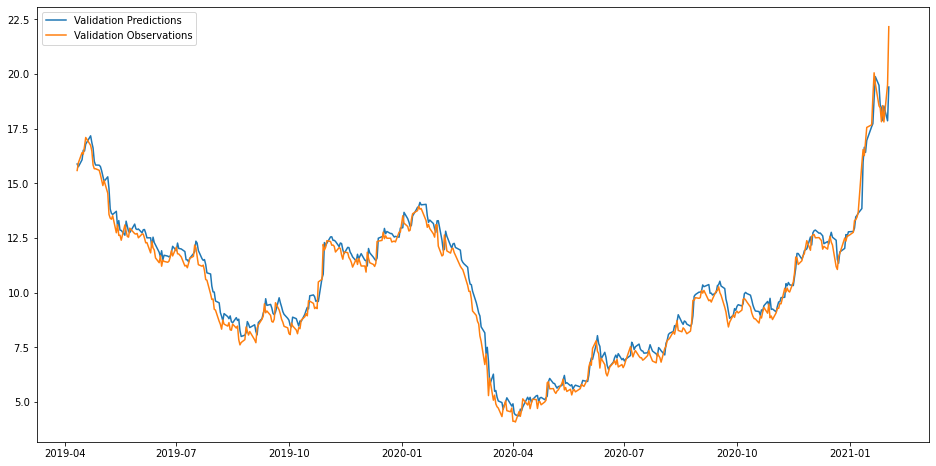

In [ ]:
val_predictions = model.predict(inputVal).flatten()
plt.figure(figsize=(16,8))
plt.plot(datesVal, val_predictions)
plt.plot(datesVal, outputVal)
plt.legend(['Validation Predictions', 'Validation Observations'])


In [ ]:
math.sqrt(mean_squared_error(outputVal,val_predictions))

0.4737985951027065

15/15 [==============================] - 0s 3ms/step


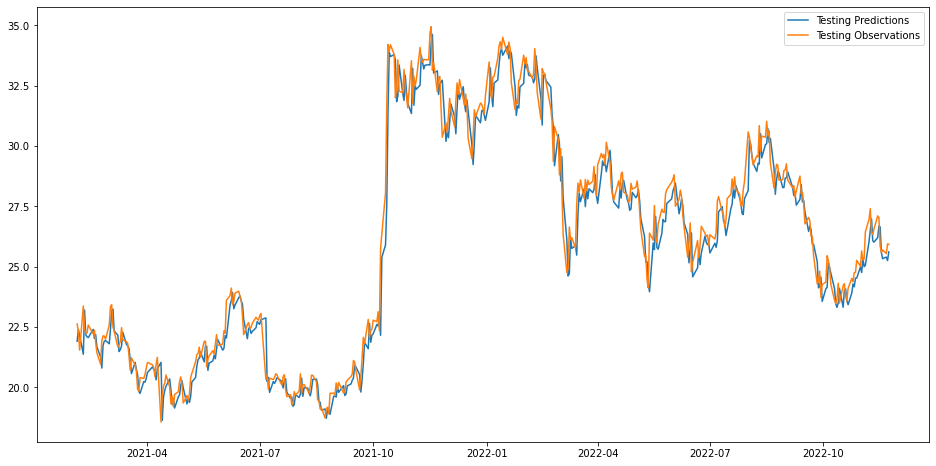

In [ ]:
test_predictions = model.predict(inputTest).flatten()
plt.figure(figsize=(16,8))
plt.plot(datesTest, test_predictions)
plt.plot(datesTest, outputTest)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [ ]:
from sklearn.metrics import *
print(mean_absolute_error(outputTest,test_predictions))
print(mean_squared_error(outputTest,test_predictions))
print(np.sqrt(mean_squared_error(outputTest,test_predictions)))

0.5689051325523327
0.608380546669663
0.7799875298167677


1/1 [==============================] - 0s 20ms/step


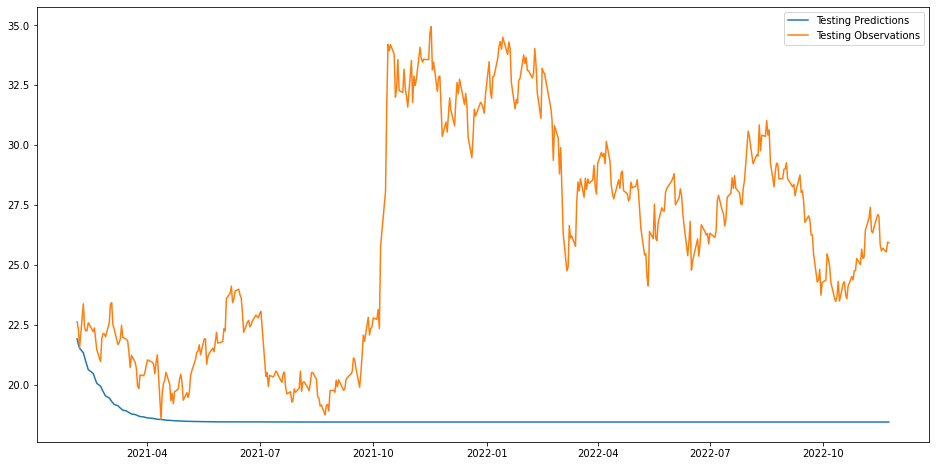

In [ ]:
import copy
output_test_prediction=[]
output_test_prediction=np.array(output_test_prediction)
temp_array_test_input=[]
temp_array_test_input=np.array(temp_array_test_input)
for i in range(len(inputTest[0])):
  temp_array_test_input=np.append(temp_array_test_input,float(inputTest[0][i]))

temp_array_test_input1=np.flip(temp_array_test_input)
# print(temp_array_test_input1)

for i in range(len(inputTest)):
  ip=temp_array_test_input[0:numberOfPrev]
  # ip=np.flip(ip)
  ip=ip.reshape(1,numberOfPrev,1)
  res=model.predict(ip).flatten()
  output_test_prediction=np.append(output_test_prediction,res)
  temp_array_test_input=np.insert(temp_array_test_input,0,res)

plt.figure(figsize=(16,8))
plt.plot(datesTest, output_test_prediction)
plt.plot(datesTest, outputTest)
plt.legend(['Testing Predictions', 'Testing Observations'])

# print(inputTest[0])
# temp=inputTest[0].reshape(1,inputTest[0].shape[0],inputTest[0].shape[1])
# res=model.predict(temp).flatten()
# print(res)

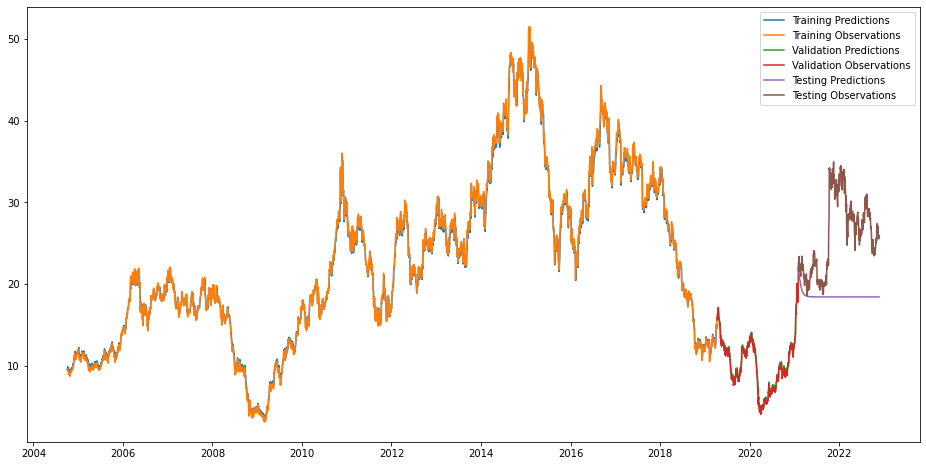

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(datesTrain, train_predictions)
plt.plot(datesTrain, outputTrain)
plt.plot(datesVal, val_predictions)
plt.plot(datesVal, outputVal)
plt.plot(datesTest, output_test_prediction)
plt.plot(datesTest, outputTest)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])